In [26]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits
import matplotlib.pyplot as plt
import numpy as np
import torch
from orbitflows import H
from time import time
from functools import partial

In [ ]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

In [232]:
def physicalPendulum(x, amp=1, freq=5):
    return amp * torch.cos(2 * torch.pi * freq * x)

In [ ]:
resolution = 200
q_ls, p_ls = torch.linspace(-1, 1, resolution), torch.linspace(-10, 10, resolution)
q, p = torch.meshgrid(q_ls, p_ls)
qp = torch.stack((q, p), dim=-1)
qp.requires_grad_(True)

tensor([[[ -1.0000, -10.0000],
         [ -1.0000,  -9.8995],
         [ -1.0000,  -9.7990],
         ...,
         [ -1.0000,   9.7990],
         [ -1.0000,   9.8995],
         [ -1.0000,  10.0000]],

        [[ -0.9899, -10.0000],
         [ -0.9899,  -9.8995],
         [ -0.9899,  -9.7990],
         ...,
         [ -0.9899,   9.7990],
         [ -0.9899,   9.8995],
         [ -0.9899,  10.0000]],

        [[ -0.9799, -10.0000],
         [ -0.9799,  -9.8995],
         [ -0.9799,  -9.7990],
         ...,
         [ -0.9799,   9.7990],
         [ -0.9799,   9.8995],
         [ -0.9799,  10.0000]],

        ...,

        [[  0.9799, -10.0000],
         [  0.9799,  -9.8995],
         [  0.9799,  -9.7990],
         ...,
         [  0.9799,   9.7990],
         [  0.9799,   9.8995],
         [  0.9799,  10.0000]],

        [[  0.9899, -10.0000],
         [  0.9899,  -9.8995],
         [  0.9899,  -9.7990],
         ...,
         [  0.9899,   9.7990],
         [  0.9899,   9.8995],
         

In [338]:
h_grid = H(qp, physicalPendulum)

Text(0, 0.5, 'p')

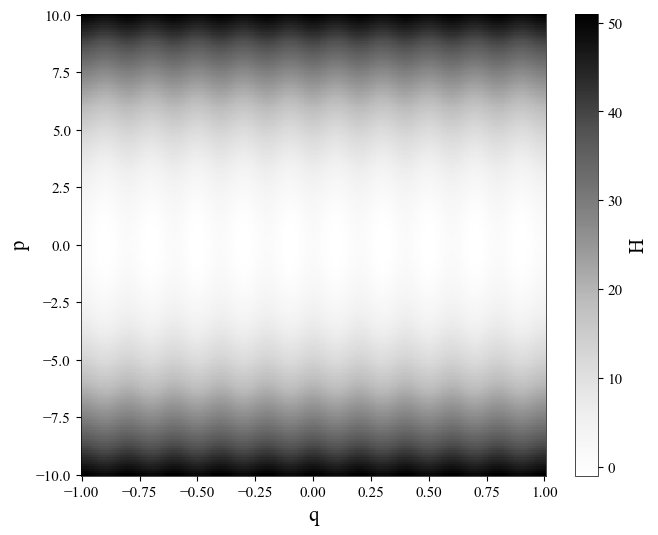

In [340]:
plt.figure(figsize=(7.5, 6))
pcm = plt.pcolormesh(q.detach().numpy(), p.detach().numpy(), h_grid.detach().numpy(), cmap='Grays')
plt.colorbar(pcm)
pcm.colorbar.set_label('H', fontsize=15)
# pcm.set_clim(vmin=error_grid.min().item(), vmax=-error_grid.min().item())
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)

In [341]:
from orbitflows.integrate.correction import dH_dx
from tqdm import tqdm

dH_dq_grid = []
dH_dp_grid = []
for ps_ in tqdm(qp.reshape((-1,2))):
    dH_dq_grid.append(dH_dx(ps_, 'q', partial(H, potential_for_H=physicalPendulum)))
    dH_dp_grid.append(dH_dx(ps_, 'p', partial(H, potential_for_H=physicalPendulum)))
dH_dq_grid = torch.tensor(dH_dq_grid).reshape(resolution, resolution)
dH_dp_grid = torch.tensor(dH_dp_grid).reshape(resolution, resolution)

100%|██████████| 40000/40000 [00:07<00:00, 5052.70it/s]


Text(0, 0.5, 'p')

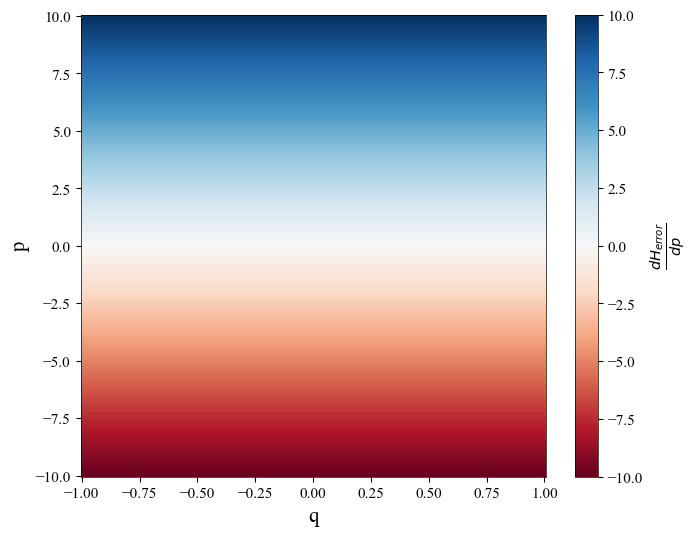

In [342]:
plt.figure(figsize=(7.5, 6))
pcm = plt.pcolormesh(q.numpy(), p.numpy(), dH_dp_grid.numpy(), cmap='RdBu', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('$\\frac{dH_{error}}{dp}$', fontsize=15)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)

Text(0, 0.5, 'p')

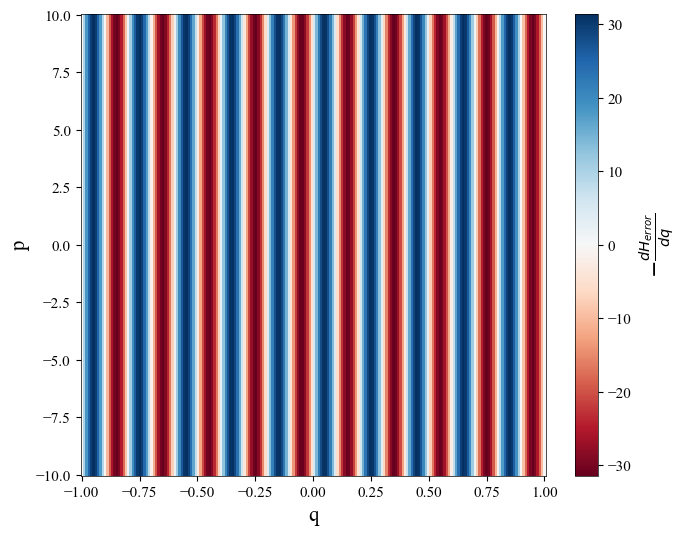

In [343]:
plt.figure(figsize=(7.5, 6))
pcm = plt.pcolormesh(q.numpy(), p.numpy(), dH_dq_grid.numpy(), cmap='RdBu')
plt.colorbar(pcm)
pcm.colorbar.set_label('$-\\frac{dH_{error}}{dq}$', fontsize=15)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)

In [285]:
from orbitflows.integrate import rungekutta4, eulerstep

In [237]:
def integrate(ps, dt, finaltime, potential, stepfunct=rungekutta4):
    steps = int(finaltime/dt)
    qp = torch.zeros((steps, 2))
    qp[0] = ps
    for i in range(steps - 1):
        qp[i + 1] = stepfunct(qp[i], dt, partial(H, potential_for_H=potential))
    return qp

In [261]:
dt = 0.01
finaltime = 1
steps= int(finaltime/dt)
n_orbits = torch.tensor(20)
n_res = torch.tensor(30)
#p0_list = torch.linspace(-2, 2, int(torch.sqrt(n_orbits)))
#q0_list = #torch.linspace(-2, 2, int(torch.sqrt(n_orbits)))
ps_evolved = torch.zeros(n_orbits + n_res, steps, 2)
for i, sign in enumerate([-1, 1]):
    for j, p0 in enumerate(torch.linspace(0, 5, int(n_orbits/2))):
        ps0 = torch.tensor([0.5 * sign, -sign * p0], requires_grad=True)
        ps_evolved[i * int(n_orbits/2) + j] = integrate(ps0, dt, finaltime, physicalPendulum)

for i, q0 in enumerate(torch.tensor([-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])):
    for j, p0 in enumerate(torch.linspace(0, 2, 5)):
        ps0 = torch.tensor([q0, p0], requires_grad=True)
        ps_evolved[n_orbits + (i * 5) + j] = integrate(ps0, dt, finaltime, physicalPendulum)
# for i, p0 in enumerate(p0_list):
#     for j, q0 in enumerate(q0_list):
#         ps0 = torch.tensor([q0, p0], requires_grad=True)
#         ps_evolved[i * int(torch.sqrt(n_orbits)) + j] = integrate(ps0, dt, finaltime, physicalPendulum)

(-5.0, 5.0)

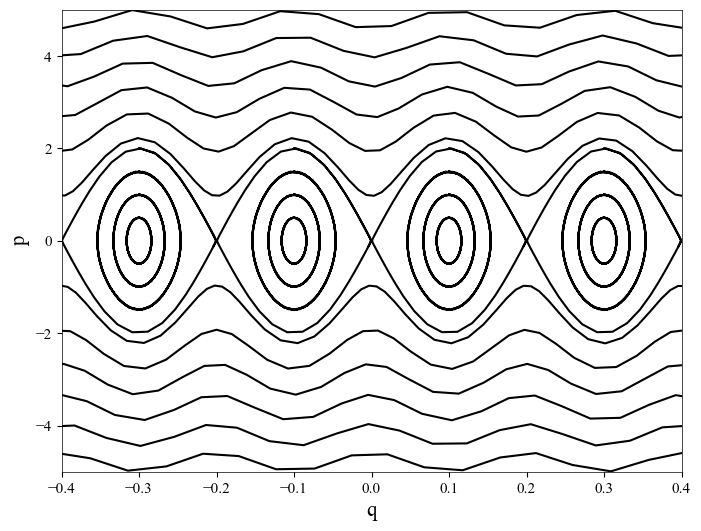

In [262]:
plt.plot(*ps_evolved.T.detach(), c='k')
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
plt.xlim(-0.4, 0.4)
plt.ylim(-5, 5)

In [318]:
ps0 = torch.tensor([0.01, 0.1], requires_grad=True)
ps_rk4 = integrate(ps0, dt, finaltime, physicalPendulum, stepfunct=rungekutta4)
ps_euler = integrate(ps0, dt, finaltime, physicalPendulum, stepfunct=eulerstep)

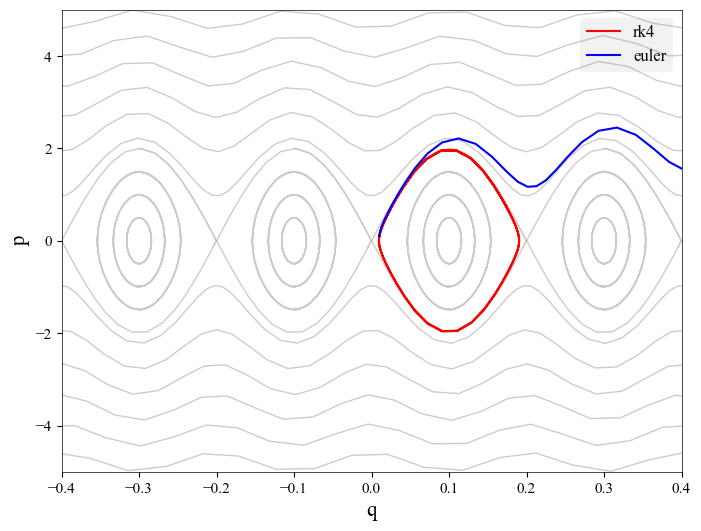

In [323]:
plt.plot(*ps_evolved.T.detach(), c='k', lw=1, alpha=0.2)
plt.plot(*ps_rk4.T.detach(), c='r', label='rk4')
plt.plot(*ps_euler.T.detach(), c='b', label='euler')
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
plt.xlim(-0.4, 0.4)
plt.ylim(-5, 5)
plt.legend(loc='upper right', fontsize=12)

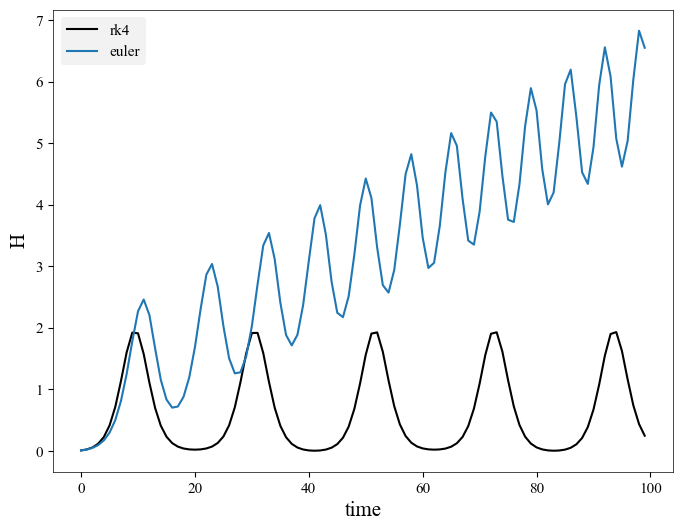

In [320]:
plt.plot(H(ps_rk4, isoDiskPotential).detach(), label='rk4')
plt.plot(H(ps_euler, isoDiskPotential).detach(), label='euler')
plt.xlabel('time', fontsize=15)
plt.ylabel('H', fontsize=15)
plt.legend()